# Imports

In [1]:
import sys
import logging
import shutil
from uuid import uuid4
from tempfile import gettempdir
from os.path import join, isdir
import folium
from aequilibrae import Parameters, logger, Project
import pandas as pd

In [2]:
from functions.country_borders import get_country_borders
from functions.map_path import map_single_path
from functions.map_modes import map_all_modes

# Model place (Country) to build the model for

In [3]:
model_place = 'Andorra'

# Environment setup

In [4]:
stdout_handler = logging.StreamHandler(sys.stdout)
formatter = logging.Formatter("%(asctime)s;%(name)s;%(levelname)s ; %(message)s")
stdout_handler.setFormatter(formatter)
logger.addHandler(stdout_handler)

In [5]:
fldr = f'../{model_place}'

if isdir(fldr):
  shutil.rmtree(fldr)

# Create Road Network from OSM

In [6]:
project = Project()
project.new(fldr)

/srv/conda/envs/saturn/lib/python3.9/site-packages/aequilibrae/parameters.py:53: UserWarning: No pre-existing parameter file exists for this project. Will use default
  warn('No pre-existing parameter file exists for this project. Will use default')


2022-05-12 00:40:57,064;aequilibrae;INFO ; Created project on ../Andorra


In [7]:
new_fields = [{'bridge': {'description': 'bridge flag', 'osm_source': 'bridge', 'type': 'text'}},
              {'tunnel': {'description': 'tunnel flag', 'osm_source': 'tunnel', 'type': 'text'}},
              {'toll': {'description': 'toll flag', 'osm_source': 'toll', 'type': 'text'}},
              {'surface': {'description': 'pavement surface', 'osm_source': 'surface', 'type': 'text'}}]

par = Parameters()
par.parameters['network']['links']['fields']['one-way'].extend(new_fields)
par.write_back()

In [8]:
%%time
project.network.create_from_osm(place_name=model_place)

2022-05-12 00:40:58,534;aequilibrae;INFO ; PLACE FOUND:Andorra
2022-05-12 00:40:58,595;aequilibrae;INFO ; Downloading data
2022-05-12 00:40:58,875;aequilibrae;DEBUG ; Downloading polygon 1 of 1
2022-05-12 00:41:08,886;aequilibrae;DEBUG ; Posting to http://overpass-api.de/api/interpreter with timeout=540, "{'data': '[out:json][timeout:540];(way["highway"]["area"!~"yes"]["highway"!~"proposed|raceway|construction|abandoned|platform"]["service"!~"parking|parking_aisle|driveway|private|emergency_access"]["access"!~"private"](42.428824,1.413578,42.655936,1.786664);>;);out;'}"
2022-05-12 00:41:11,269;aequilibrae;INFO ; Downloaded 15,669.3KB from overpass-api.de in 2.38 seconds
2022-05-12 00:41:11,749;aequilibrae;INFO ; Building Network
2022-05-12 00:41:11,820;aequilibrae;INFO ; Separating nodes and links
2022-05-12 00:41:12,863;aequilibrae;INFO ; Setting data structures for nodes
2022-05-12 00:41:13,682;aequilibrae;INFO ; Setting data structures for links
2022-05-12 00:41:13,721;aequilibrae;I

# Restricts import to the country's borders only

In [9]:
place_geo = get_country_borders(model_place)

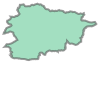

In [10]:
place_geo

In [11]:
project.conn.execute('CREATE TABLE IF NOT EXISTS country_borders("country_name" TEXT);')
project.conn.execute("SELECT AddGeometryColumn( 'country_borders', 'geometry', 4326, 'MULTIPOLYGON', 'XY' );")

project.conn.execute("SELECT CreateSpatialIndex( 'country_borders' , 'geometry' );")
project.conn.commit()
project.conn.execute('INSERT into country_borders(country_name, geometry) VALUES(?, GeomFromWKB(?, 4326));', [model_place, place_geo.wkb])
project.conn.commit()

In [12]:
%%time
sql = """DELETE from Links where link_id not in (SELECT a.link_id
FROM links AS a, country_borders as b
WHERE ST_Intersects(a.geometry, b.geometry) = 1)"""

project.conn.execute(sql)
project.conn.commit()

CPU times: user 368 ms, sys: 42.9 ms, total: 411 ms
Wall time: 520 ms


# Displays the network

In [13]:
map_all_modes(project)

# We test how would path computation work

In [14]:
from aequilibrae.paths import PathResults

In [15]:
project.conn.execute('update nodes set is_centroid=1')
project.conn.commit()

project.network.build_graphs()
graph = project.network.graphs['c']

# we also see what graphs are available
# project.network.graphs.keys()

# let's say we want to minimize distance
graph.set_graph('distance')

# And will skim time and distance while we are at it
graph.set_skimming(['distance'])

graph.set_blocked_centroid_flows(False)

2022-05-12 00:42:08,696;aequilibrae;WARNING ; Field(s) speed, capacity, lanes has(ve) at least one NaN value. Check your computations
2022-05-12 00:42:08,840;aequilibrae;WARNING ; Field(s) speed, capacity, lanes has(ve) at least one NaN value. Check your computations
2022-05-12 00:42:08,961;aequilibrae;WARNING ; Field(s) speed, capacity, lanes has(ve) at least one NaN value. Check your computations
2022-05-12 00:42:09,098;aequilibrae;WARNING ; Field(s) speed, capacity, lanes has(ve) at least one NaN value. Check your computations


In [16]:
res = PathResults()
res.prepare(graph)

sql = 'select node_id, modes from nodes where modes like "%c%"'
df_nodes = pd.read_sql(sql, project.conn)

while True:
    o,d = df_nodes.node_id.sample(2).values
    res.compute_path(o, d)
    if res.path.shape[0]:
        break

In [17]:
map_single_path(project, res)

In [18]:
project.close()

2022-05-12 00:42:09,336;aequilibrae;INFO ; Closed project on ../Andorra
